An implementation for porting to other platforms and discussion (this is not to do exploratory analysis but rather to consider the APIs and technologies involved - it is not intended to be a good or reference solution to this problem). 

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
import databricks.koalas as ks
import pyspark.pandas as ps
import seaborn as sns

In [2]:
ks.set_option('compute.default_index_type', 'distributed')

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/12/19 11:52:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Obtain the data from Google Cloud Storage buckets

In [3]:
! wget https://storage.googleapis.com/bdt-spark-store/external_sources.csv -O gcs_external_sources.csv

--2021-12-19 11:52:28--  https://storage.googleapis.com/bdt-spark-store/external_sources.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.170.48, 172.217.170.80, 172.217.170.112, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.170.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15503836 (15M) [text/csv]
Saving to: ‘gcs_external_sources.csv’

gcs_external_source 100%[===================>]  14.79M  3.34MB/s    in 5.0s    

2021-12-19 11:52:34 (2.98 MB/s) - ‘gcs_external_sources.csv’ saved [15503836/15503836]



In [4]:
! wget https://storage.googleapis.com/bdt-spark-store/internal_data.csv -O gcs_internal_data.csv

--2021-12-19 11:52:34--  https://storage.googleapis.com/bdt-spark-store/internal_data.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.170.80, 172.217.170.112, 172.217.170.16, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.170.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 152978396 (146M) [text/csv]
Saving to: ‘gcs_internal_data.csv’

gcs_internal_data.c 100%[===================>] 145.89M  2.89MB/s    in 43s     

2021-12-19 11:53:19 (3.38 MB/s) - ‘gcs_internal_data.csv’ saved [152978396/152978396]



Read in data sources

In [5]:
df_data = ks.read_csv('gcs_internal_data.csv')
df_ext = ks.read_csv('gcs_external_sources.csv')

Join them on their common identifier key

In [6]:
df_full = df_data.merge(df_ext, on='SK_ID_CURR', how='inner').sort_index()
df_full.head()

21/12/19 11:53:33 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
/Users/jeandre/opt/anaconda3/envs/DS/lib/python3.8/site-packages/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3
0,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.0959,0.0529,0.9851,0.796,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.0790,0.0554,0.0000,0.0000,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.0100,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.311267,0.622246,NaN
1,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,NaN,1,1,0,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,Religion,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,None,None,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.322738,NaN
2,100020,0,Cash loans,M,N,N,0,108000.0,509602.5,26149.5,387000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.018634,-12931,-1317,-6392.0,-3866,NaN,1,1,0,1,0,0,Drivers,2.0,2,2,THURSDAY,12,0,0,0,1,1,0,Government,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,None,None,0.0,0.0,0.0,0.0,-3.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,NaN,0.236378,0.062103
3,100035,0,Cash loan

We will filter a few features out for the sake of this example

In [7]:
columns_extract = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
                  'DAYS_BIRTH', 'DAYS_EMPLOYED', 'NAME_EDUCATION_TYPE',
                  'DAYS_ID_PUBLISH', 'CODE_GENDER', 'AMT_ANNUITY',
                  'DAYS_REGISTRATION', 'AMT_GOODS_PRICE', 'AMT_CREDIT',
                  'ORGANIZATION_TYPE', 'DAYS_LAST_PHONE_CHANGE',
                  'NAME_INCOME_TYPE', 'AMT_INCOME_TOTAL', 'OWN_CAR_AGE', 'TARGET']
df = df_full[columns_extract]

In [8]:
df.head(3)

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,DAYS_EMPLOYED,NAME_EDUCATION_TYPE,DAYS_ID_PUBLISH,CODE_GENDER,AMT_ANNUITY,DAYS_REGISTRATION,AMT_GOODS_PRICE,AMT_CREDIT,ORGANIZATION_TYPE,DAYS_LAST_PHONE_CHANGE,NAME_INCOME_TYPE,AMT_INCOME_TOTAL,OWN_CAR_AGE,TARGET
0,0.311267,0.622246,NaN,-16765,-1188,Higher education,-291,F,35698.5,-1186.0,1129500.0,1293502.5,School,-828.0,State servant,270000.0,NaN,0
1,NaN,0.322738,NaN,-19932,-3038,Secondary / secondary special,-3458,M,21865.5,-4311.0,513000.0,513000.0,Religion,-1106.0,Working,121500.0,NaN,0
2,NaN,0.236378,0.062103,-12931,-1317,Secondary / secondary special,-3866,M,26149.5,-6392.0,387000.0,509602.5,Government,-3.0,Working,108000.0,NaN,0


Let's obtain a train and test split

In [9]:
# set the seed for reproducibility
np.random.RandomState(101)

RandomState(MT19937) at 0x7FF0AF1EC140

In [10]:

train, test = np.split(df.sample(frac=1.00), [int(.8*len(df))])

In [11]:
print(train.TARGET.value_counts()/len(train.index))
print(test.TARGET.value_counts()/len(test.index))

0    0.919547
1    0.080453
Name: TARGET, dtype: float64
0    0.918167
1    0.081833
Name: TARGET, dtype: float64


Handle the categorical variables

In [12]:
train = ks.get_dummies(train)
test = ks.get_dummies(test)

print('Training Features shape: ', train.shape)
print('Testing Features shape: ', test.shape)

Training Features shape:  (246008, 88)
Testing Features shape:  (61503, 87)


Align the training and test data (as the test data may not have the same columns in the encoding)

In [13]:
# Align the training and testing data, keep only columns present in both dataframes
train, test = train.align(test, join = 'inner', axis = 1)

print('Training Features shape: ', train.shape)
print('Testing Features shape: ', test.shape)

Training Features shape:  (246008, 87)
Testing Features shape:  (61503, 87)


Get labels from data

In [14]:
train_labels = train['TARGET']
test_labels = test['TARGET']

Fill in missing data and scale

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer as Imputer

# Drop the target from the training data
if 'TARGET' in train:
    train = train.drop(columns = ['TARGET'])
    test = test.drop(columns = ['TARGET'])
else:
    train = train.copy()
    test = test.copy()
    
train = train.to_pandas()    #at this point I gave up
test = test.to_pandas()
train_labels = train_labels.to_pandas()    #at this point I gave up
test_labels = test_labels.to_pandas()
    
# Feature names
features = list(train.columns)

# Median imputation of missing values
imputer = Imputer(strategy = 'median')

# Scale each feature to 0-1
scaler = StandardScaler()

# Fit on the training data
imputer.fit(train)

# Transform both training and testing data
train = imputer.transform(train)
test = imputer.transform(test)

scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

Training data shape:  (246008, 86)
Testing data shape:  (61503, 86)


Fit random forest

In [16]:
from sklearn.ensemble import RandomForestClassifier

# Make the random forest classifier
random_forest = RandomForestClassifier(n_estimators = 100, 
                                       random_state = 50, 
                                       verbose = 1, n_jobs = -1)
# Train on the training data
random_forest.fit(train, train_labels)

# Extract feature importances
feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

# Make predictions on the test data
predictions = random_forest.predict(test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   17.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished


Evaluate on test

In [17]:
from sklearn.metrics import accuracy_score, roc_auc_score

print(accuracy_score(test_labels, predictions))

0.9181828528689657


In [18]:
feature_importances.sort_values('importance', ascending=False).head(10)

,feature,importance
13,EXT_SOURCE_2,0.099201
14,EXT_SOURCE_3,0.086540
7,DAYS_BIRTH,0.077547
9,DAYS_ID_PUBLISH,0.076034
11,DAYS_REGISTRATION,0.075331
0,AMT_ANNUITY,0.071372
10,DAYS_LAST_PHONE_CHANGE,0.067874
8,DAYS_EMPLOYED,0.064817
1,AMT_CREDIT,0.064738
3,AMT_INCOME_TOTAL,0.056704


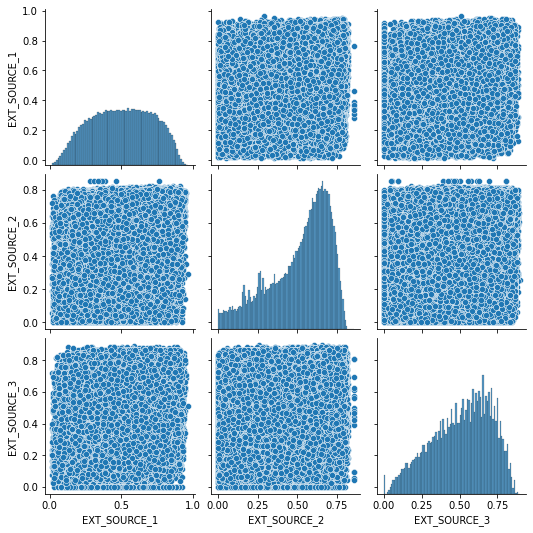

In [19]:
pairplot_pd = df_full[["EXT_SOURCE_1","EXT_SOURCE_2","EXT_SOURCE_3"]].to_pandas() #even databricks takes this to a pandas df
sns.pairplot(pairplot_pd)